# Emissão de Raios-X - Análise de dados

Notebook com análise de dados do experimento de emissão de raios-x por cristais de cloreto de sódio (NaCl) e brometro de potássio (KBr).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.signal import find_peaks
from scipy.constants import h as planck, c, e
from scipy.optimize import curve_fit

h = planck / e

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

In [ ]:
df = { 'NaCl': [], 'KBr': [] }

In [ ]:
labels    = { 'voltages': [ '35kV', '30kV', '26kV', '22kV', '18kV' ] }
voltages  = [ 35E3, 30E3, 26E3, 22E3, 18E3 ]
lattice   = { 'NaCl': 0.564E-9, 'KBr': 0.659E-9 }
energies  = { 'Mo': np.array([  19.6083E3, 17.47934E3 ]) }
data_fit  = { 'NaCl': [], 'KBr': [] }
curves    = { 'NaCl': [], 'KBr': [] }

# Discussão qualitativa dos espectros de emissão do $NaCl$ e do $KBr$

## $NaCl$ - Cloreto de Sódio

In [ ]:
df['NaCl'] = pd.read_csv('nacl.csv')

In [ ]:
# Ângulo de acquisição (converte para radianos e adiciona incerteza)
df['NaCl']['beta']        = np.radians(df['NaCl']['beta'])
df['NaCl']['sBeta']       = np.zeros(df['NaCl'].shape[0]) + np.radians(0.05)

# Comprimento de onda e sua incerteza
df['NaCl']['wavelength']  = lattice['NaCl'] * np.sin(df['NaCl']['beta'])
df['NaCl']['sWavelength'] = np.sqrt( df['NaCl']['sBeta']**2 * (lattice['NaCl'] * np.cos(df['NaCl']['beta']) )**2 )

# Energia dos fótons e sua incerteza
df['NaCl']['energy']      = h * c / df['NaCl']['wavelength']
df['NaCl']['sEnergy']     = np.sqrt( df['NaCl']['sWavelength']**2 * (h * c / df['NaCl']['wavelength']**2)**2 )

In [ ]:
peaks, props = find_peaks(df['NaCl']['R0'], prominence=150)
peaks = peaks[1:]
peaks = np.insert(peaks, 4, 171)

In [ ]:
peaks_beta    = list(df['NaCl']['beta'][peaks])
peaks_energy  = list(df['NaCl']['energy'][peaks])
peaks_sigma   = list(df['NaCl']['sEnergy'][peaks])
peaks_wl      = list(df['NaCl']['wavelength'][peaks])
peaks_flux    = list(df['NaCl']['R0'][peaks])

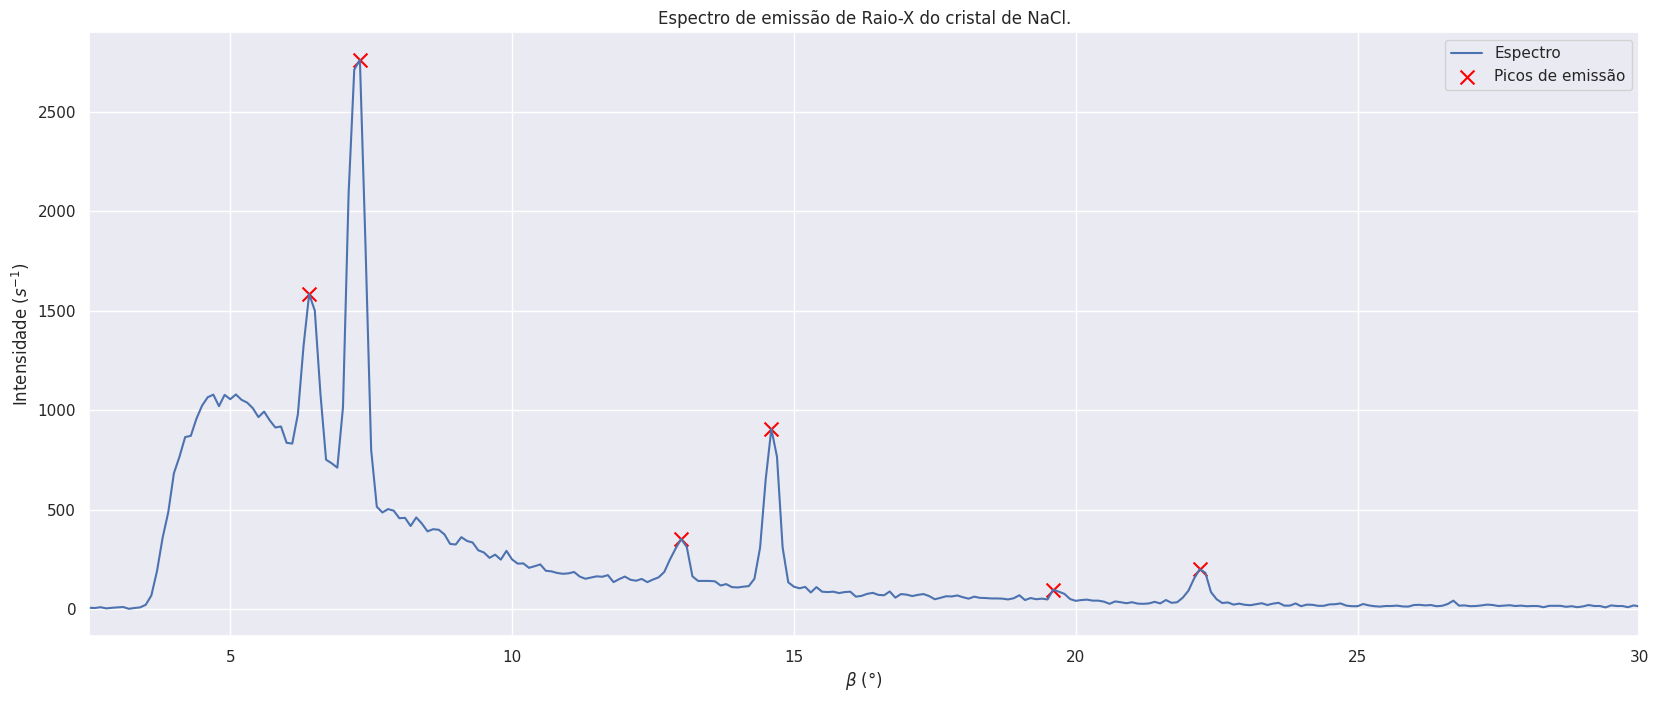

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

sns.lineplot(x=np.degrees(df['NaCl']['beta']), y=df['NaCl']['R0'], label='Espectro')
plt.scatter(np.degrees(peaks_beta), peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('$\\beta$ (°)')
plt.ylabel('Intensidade ($s^{-1}$)')
plt.xlim(2.5, 30)
plt.legend()

plt.show()

O gráfico do espectro de emissão de raios-x para o cristal de $NaCl$ está de acordo com o esperado. Temos o espectro do emissor de raios-x devido ao efeito de freamento dos elétrons e os picos característicos de emissão do filtro de Molibdênio. Cada par de pico corresponde a um valor diferente para o índice de difração $n$ no interior da rede cristalina.

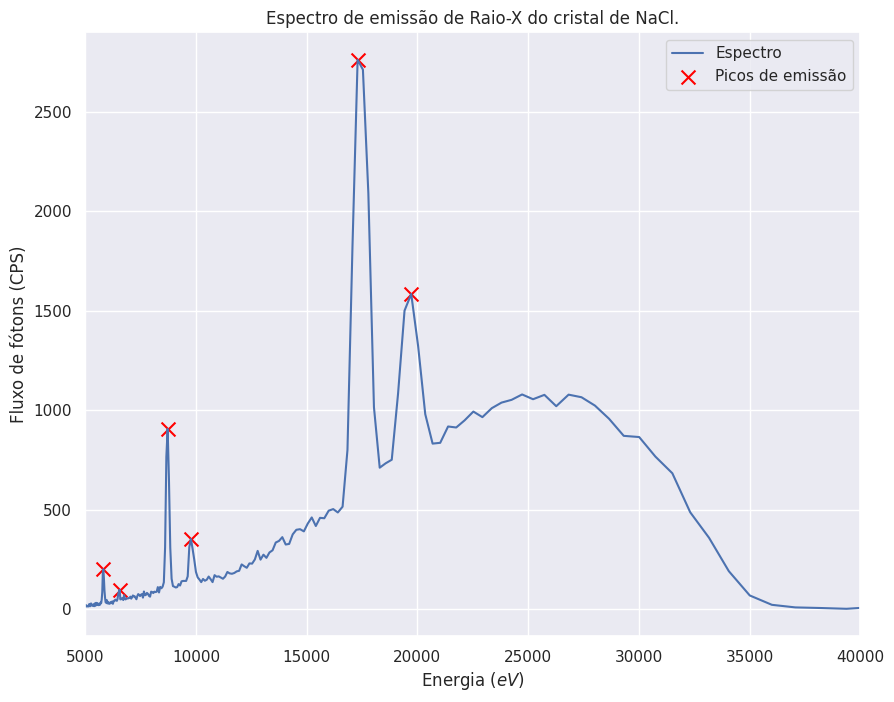

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

sns.lineplot(data=df['NaCl'], x='energy', y='R0', label='Espectro')
plt.scatter(peaks_energy, peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('Energia ($eV$)')
plt.ylabel('Fluxo de fótons (CPS)')
plt.xlim(5E3, 40E3)
plt.legend()

plt.show()

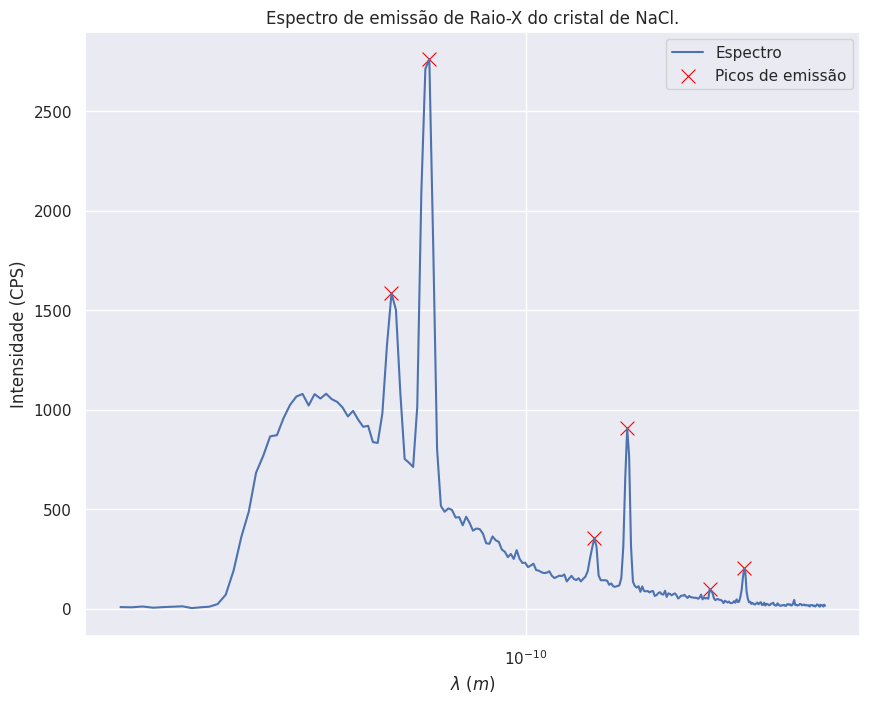

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

sns.lineplot(data=df['NaCl'], x='wavelength', y='R0', label='Espectro')
sns.scatterplot(x=peaks_wl, y=peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('$\\lambda$ ($m$)')
plt.ylabel('Intensidade (CPS)')
plt.xscale('log')
plt.legend()

plt.show()

Do espectro acima, podemos ver a formação de 6 picos característicos. Discriminamos todos eles de acordo com sua altura usando a função `find_peaks` do módulo scipy.

In [ ]:
exp_betas = []
for i in range(1, 4):
  exp_betas = np.append(exp_betas, np.degrees(np.arcsin(i * h * c / ( lattice['NaCl'] * energies['Mo'] ))) )

In [ ]:
exp_betas

array([ 6.43700591,  7.224976  , 12.95710482, 14.56815079, 19.65357335,
       22.16635856])

In [ ]:
for i in range(len(peaks_energy)): print('[P{}]:\t{:.5e} eV\t{:.5e} eV\t{:.5f} A\t{:.1f}'.format(i, peaks_energy[i], peaks_sigma[i], peaks_wl[i]*1E10, np.degrees(peaks_beta[i])))

[P0]:	1.97212e+04 eV	1.53431e+02 eV	0.62868 A	6.4
[P1]:	1.73007e+04 eV	1.17856e+02 eV	0.71664 A	7.3
[P2]:	9.77235e+03 eV	3.69388e+01 eV	1.26872 A	13.0
[P3]:	8.72102e+03 eV	2.92173e+01 eV	1.42167 A	14.6
[P4]:	6.55326e+03 eV	1.60603e+01 eV	1.89195 A	19.6
[P5]:	5.81806e+03 eV	1.24413e+01 eV	2.13102 A	22.2


### Ajuste de pico gaussiano

In [ ]:
def gaussian(x, H, A, x0, sigma): return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

Definimos os intervalos para fazer os ajustes gaussianos ao picos de emissão

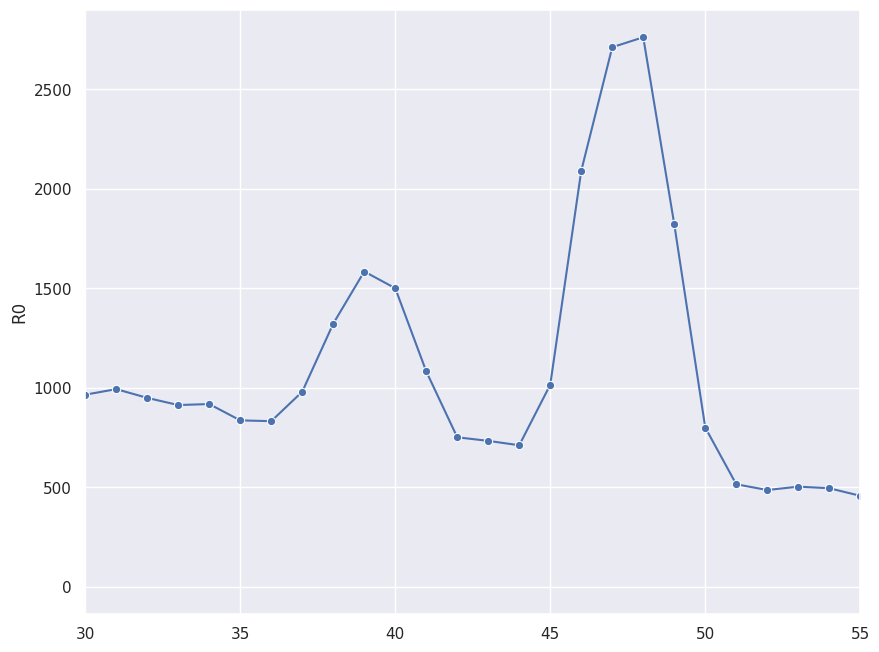

In [ ]:
sns.lineplot(x=range(df['NaCl'].shape[0]), y=df['NaCl']['R0'], marker='o')
plt.xlim(30, 55)
plt.show()

In [ ]:
ranges = ((37, 43), (44, 53))

In [ ]:
gauss_fits = []

In [ ]:
for i in range(2):
  popt, pcov = curve_fit(
    gaussian,
    xdata=df['NaCl']['energy'][ranges[i][0]:ranges[i][1]],
    ydata=df['NaCl']['R0'][ranges[i][0]:ranges[i][1]],
    p0=(0, peaks_flux[i], peaks_energy[i], 1000)
  )
  gauss_fits.append(popt)

In [ ]:
gauss_fits

[array([  449.6024292 ,  1145.96666541, 19679.21413437,   521.28524256]),
 array([  449.48847229,  2463.93885862, 17457.65094991,   345.22820677])]

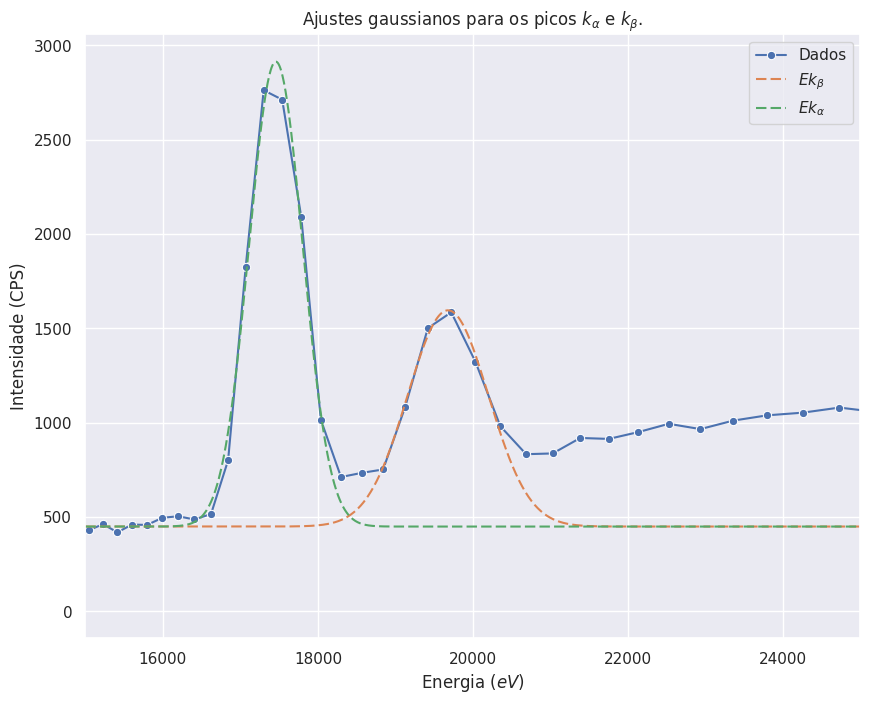

In [ ]:
plt.title('Ajustes gaussianos para os picos $k_{\\alpha}$ e $k_{\\beta}$.')
sns.lineplot(data=df['NaCl'], x='energy', y='R0', marker='o', label='Dados')

x = np.linspace(15000, 25000, 1000)
klabels = ('$Ek_{\\beta}$', '$Ek_{\\alpha}$')
for i in range(2):
  popt = gauss_fits[i]
  sns.lineplot(x=x, y=gaussian(x, popt[0], popt[1], popt[2], popt[3]), label=klabels[i], dashes=(5, 2))

plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(15000, 25000)
plt.legend()

plt.show()

In [ ]:
for i in range(2): print('{}:\t{:.5f} eV\t{:.5f} eV'.format(klabels[i], gauss_fits[i][2], gauss_fits[i][3]))

$Ek_{\beta}$:	19679.21413 eV	521.28524 eV
$Ek_{\alpha}$:	17457.65095 eV	345.22821 eV


## $KBr$ - Brometo de Potássio

In [ ]:
df['KBr'] = pd.read_csv('kbr.csv')

In [ ]:
# Ângulo de acquisição (converte para radianos e adiciona incerteza)
df['KBr']['beta']        = np.radians(df['KBr']['beta'])
df['KBr']['sBeta']       = np.zeros(df['KBr'].shape[0]) + np.radians(0.1)

# Comprimento de onda e sua incerteza
df['KBr']['wavelength']  = lattice['KBr'] * np.sin(df['KBr']['beta'])
df['KBr']['sWavelength'] = np.sqrt( df['KBr']['sBeta']**2 * (lattice['KBr'] * np.cos(df['KBr']['beta'] ))**2 )

# Energia dos fótons e sua incerteza
df['KBr']['energy']      = h * c / df['KBr']['wavelength']
df['KBr']['sEnergy']     = np.sqrt( df['KBr']['sWavelength']**2 * (h * c / df['KBr']['wavelength']**2)**2 )

In [ ]:
peaks, props = find_peaks(df['KBr']['R0'], prominence=60)
peaks = peaks[1:]
peaks = np.insert(peaks, 4, 140)

In [ ]:
peaks_energy  = list(df['KBr']['energy'][peaks])
peaks_sigma   = list(df['KBr']['sEnergy'][peaks])
peaks_beta    = list(df['KBr']['beta'][peaks])
peaks_wl      = list(df['KBr']['wavelength'][peaks])
peaks_flux    = list(df['KBr']['R0'][peaks])

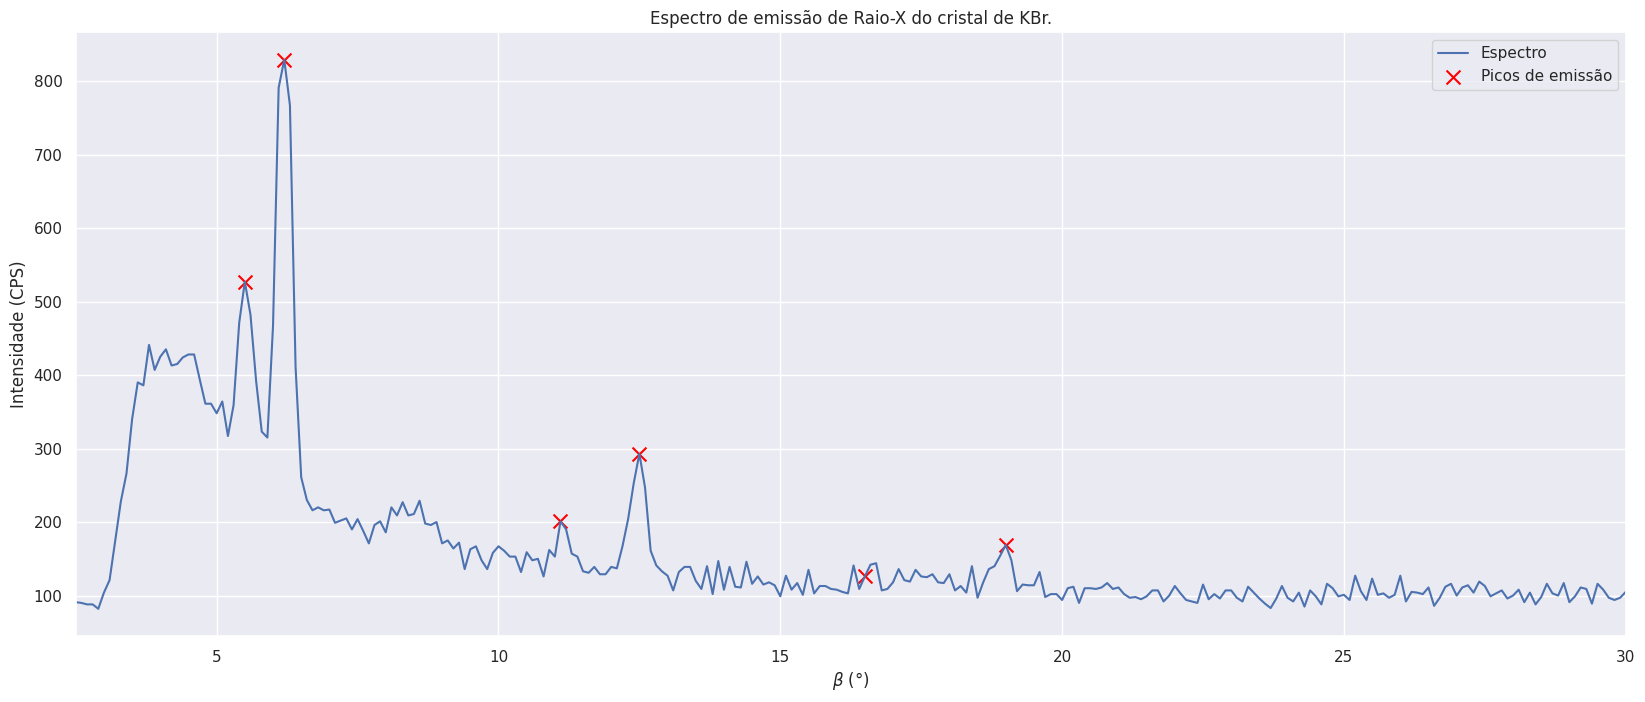

In [ ]:
plt.figure(figsize=(20,8))
plt.title('Espectro de emissão de Raio-X do cristal de KBr.')

sns.lineplot(x=np.degrees(df['KBr']['beta']), y=df['KBr']['R0'], label='Espectro')
plt.scatter(np.degrees(peaks_beta), peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('$\\beta$ (°)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(2.5, 30)
plt.legend()

plt.show()

Analogamente para o espectro do cloreto de sódio, temos o espectro de fundo devido ao efeito de freamento dos eléctrons e os picos de emissão característicos do filtro de Molibdênio. Porém, para os dados deste cristal, o tempo de aquisição dos dados $\Delta t$ deveria ter sido maior do que $1s$, pois vemos que os dados apresentam um ruído considerável.

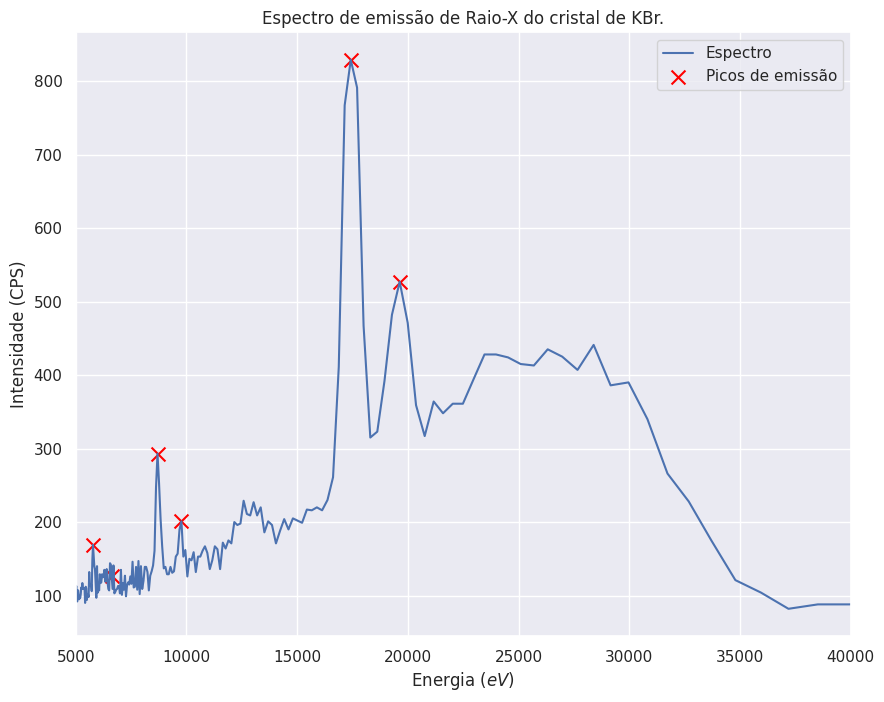

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de KBr.')

sns.lineplot(data=df['KBr'], x='energy', y='R0', label='Espectro')
plt.scatter(peaks_energy, peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(5E3, 40E3)
plt.legend()

plt.show()

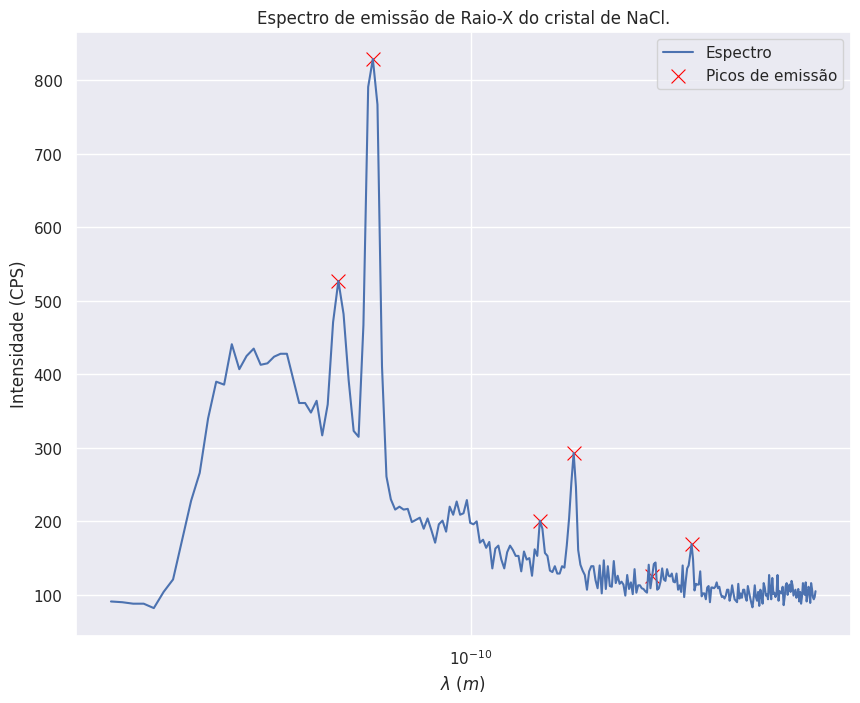

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

sns.lineplot(data=df['KBr'], x='wavelength', y='R0', label='Espectro')
sns.scatterplot(x=peaks_wl, y=peaks_flux, marker='x', s=100, color='red', label='Picos de emissão')

plt.xlabel('$\\lambda$ ($m$)')
plt.ylabel('Intensidade (CPS)')
plt.xscale('log')
plt.legend()

plt.show()

In [ ]:
exp_betas = []
for i in range(1, 4):
  exp_betas = np.append(exp_betas, np.degrees(np.arcsin(i * h * c / ( lattice['KBr'] * energies['Mo'] ))) )

In [ ]:
exp_betas

array([ 5.50594975,  6.17903553, 11.0635837 , 12.43143727, 16.72912382,
       18.83880533])

In [ ]:
for i in range(len(peaks_energy)): print('[P{}]:\t{:.5e} eV\t{:.5e} eV\t{:.5f} A\t{:.1f}'.format(i, peaks_energy[i], peaks_sigma[i], peaks_wl[i]*1E10, np.degrees(peaks_beta[i])))

[P0]:	1.96294e+04 eV	3.55802e+02 eV	0.63162 A	5.5
[P1]:	1.74205e+04 eV	2.79878e+02 eV	0.71172 A	6.2
[P2]:	9.77239e+03 eV	8.69353e+01 eV	1.26872 A	11.1
[P3]:	8.69249e+03 eV	6.84331e+01 eV	1.42634 A	12.5
[P4]:	6.62429e+03 eV	3.90312e+01 eV	1.87166 A	16.5
[P5]:	5.77882e+03 eV	2.92917e+01 eV	2.14549 A	19.0


### Ajuste de pico gaussiano

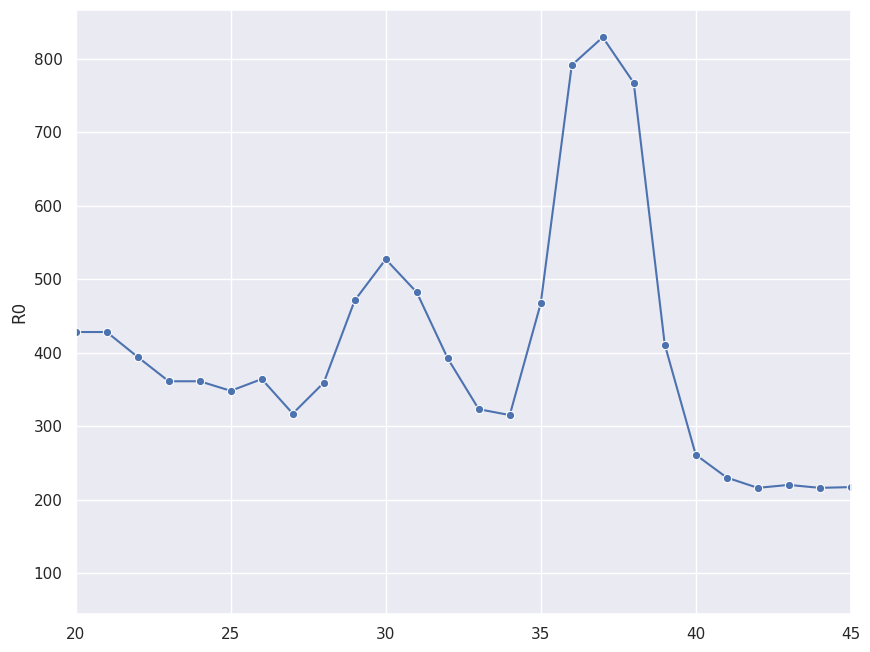

In [ ]:
sns.lineplot(x=range(df['KBr'].shape[0]), y=df['KBr']['R0'], marker='o')
plt.xlim(20, 45)
plt.show()

In [ ]:
ranges = ((28, 34), (34, 42))

In [ ]:
gauss_fits = []

In [ ]:
for i in range(2):
  popt, pcov = curve_fit(
    gaussian,
    xdata=df['KBr']['energy'][ranges[i][0]:ranges[i][1]],
    ydata=df['KBr']['R0'][ranges[i][0]:ranges[i][1]],
    p0=(0, peaks_flux[i], peaks_energy[i], 1000)
  )
  gauss_fits.append(popt)

In [ ]:
gauss_fits

[array([  281.71577314,   246.386689  , 19602.12560612,   515.2116043 ]),
 array([  204.50973699,   674.51426047, 17461.00108886,   407.00051742])]

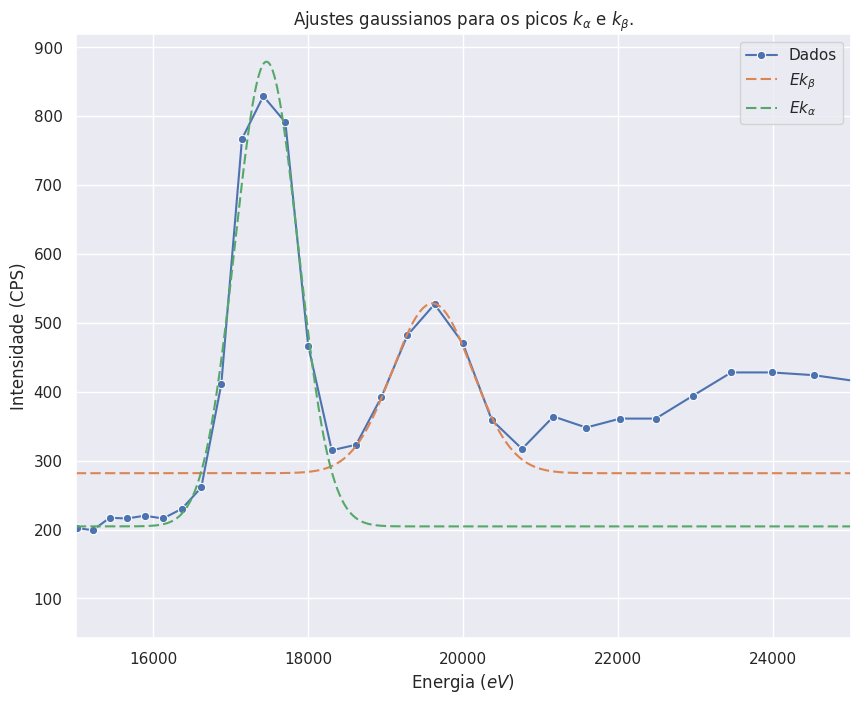

In [ ]:
plt.title('Ajustes gaussianos para os picos $k_{\\alpha}$ e $k_{\\beta}$.')
sns.lineplot(data=df['KBr'], x='energy', y='R0', marker='o', label='Dados')

x = np.linspace(15000, 25000, 1000)
klabels = ('$Ek_{\\beta}$', '$Ek_{\\alpha}$')
for i in range(2):
  popt = gauss_fits[i]
  sns.lineplot(x=x, y=gaussian(x, popt[0], popt[1], popt[2], popt[3]), label=klabels[i], dashes=(5, 2))

plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(15000, 25000)
plt.legend()

plt.show()

In [ ]:
for i in range(2): print('{}:\t{:.5f} eV\t{:.5f} eV'.format(klabels[i], gauss_fits[i][2], gauss_fits[i][3]))

$Ek_{\beta}$:	19602.12561 eV	515.21160 eV
$Ek_{\alpha}$:	17461.00109 eV	407.00052 eV


# Determinação da constante de Planck

## Visualização dos dados

### $NaCl$ - Cloreto de Sódio

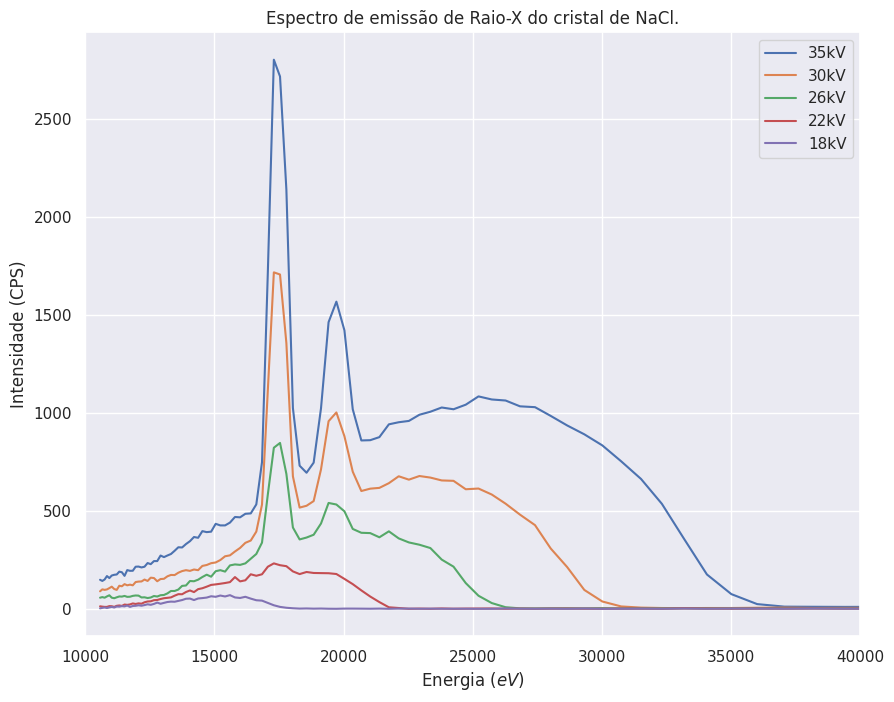

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

for i in range(1, 6):
  sns.lineplot(data=df['NaCl'], x='energy', y=f'R{i}', label=labels['voltages'][i-1])
  
plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.legend()
plt.xlim(10E3, 40E3)

plt.show()

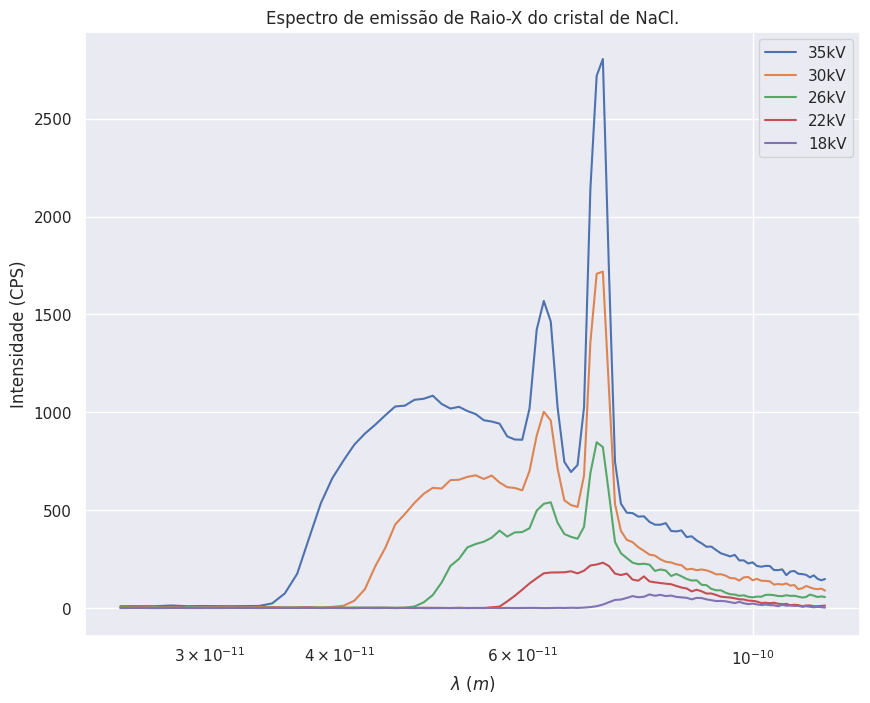

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de NaCl.')

for i in range(1, 6):
  sns.lineplot(data=df['NaCl'], x='wavelength', y=f'R{i}', label=labels['voltages'][i-1])
  
plt.xlabel('$\\lambda$ ($m$)')
plt.ylabel('Intensidade (CPS)')
plt.xscale('log')
plt.legend()

plt.show()

### $KBr$ - Brometo de Potássio

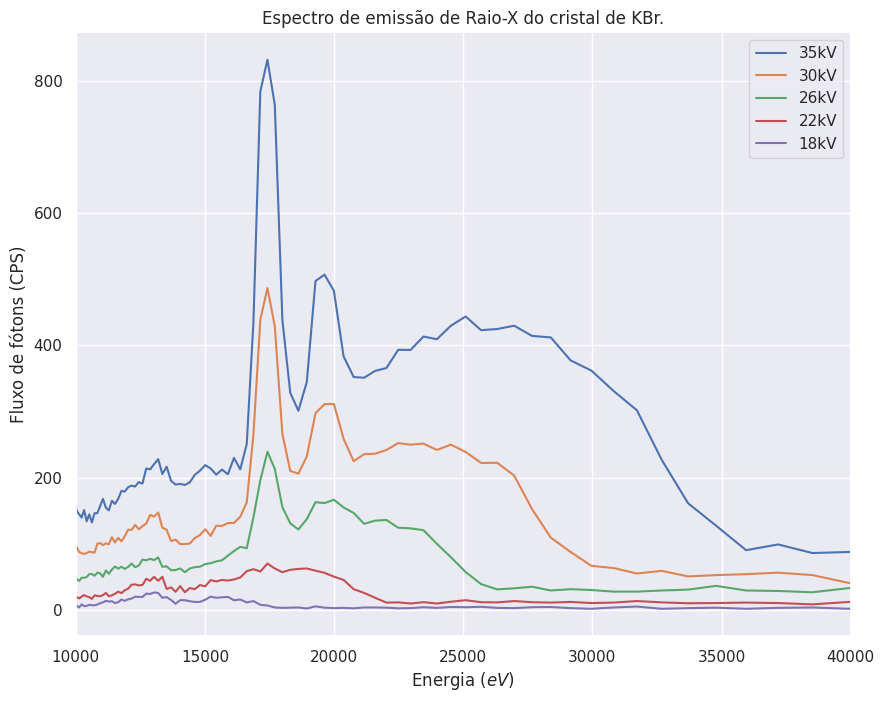

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de KBr.')

for i in range(1, 6):
  sns.lineplot(data=df['KBr'], x='energy', y=f'R{i}', label=labels['voltages'][i-1])

plt.xlabel('Energia ($eV$)')
plt.ylabel('Fluxo de fótons (CPS)')
plt.legend()
plt.xlim(10E3, 40E3)

plt.show()

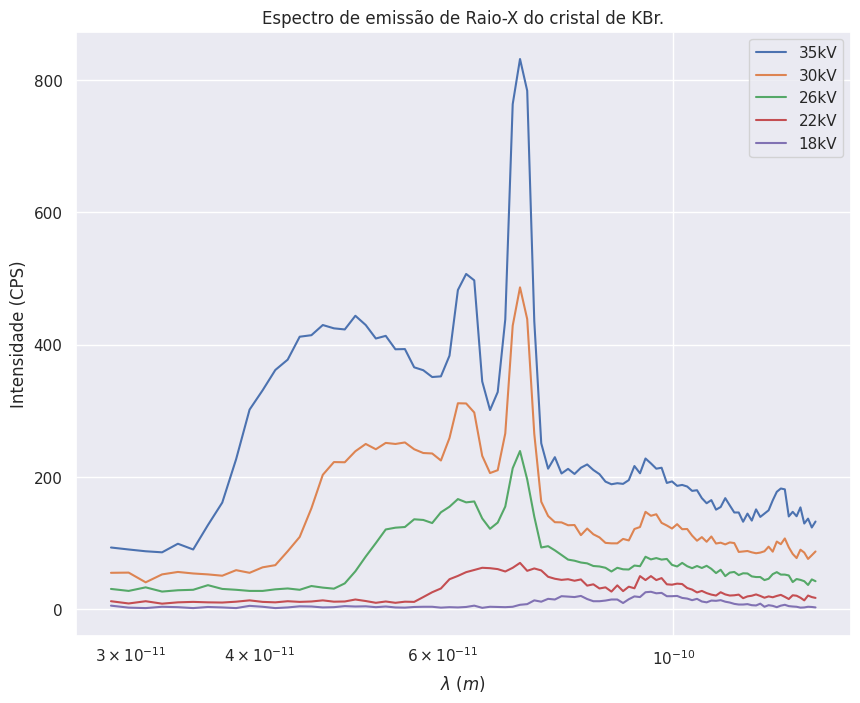

In [ ]:
plt.title('Espectro de emissão de Raio-X do cristal de KBr.')

for i in range(1, 6):
  sns.lineplot(data=df['KBr'], x='wavelength', y=f'R{i}', label=labels['voltages'][i-1])
  
plt.xlabel('$\\lambda$ ($m$)')
plt.ylabel('Intensidade (CPS)')
plt.xscale('log')
plt.legend()

plt.show()

## Ajuste para o comprimento de onda mínimo $\lambda_{min}$

### $NaCl$ - Cloreto de Sódio

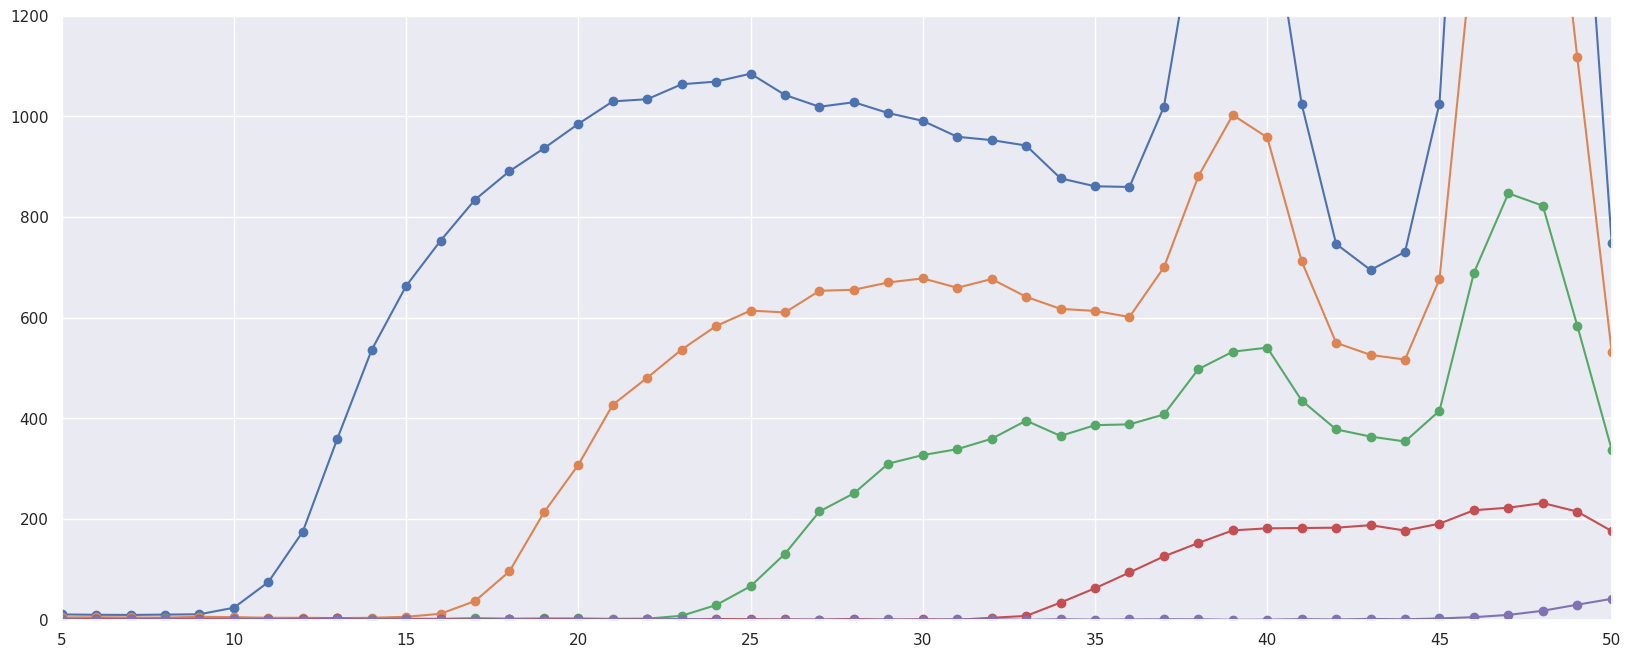

In [ ]:
plt.figure(figsize=(20,8))
for i in range(5): plt.plot(df['NaCl'][f'R{i+1}'], marker='o')
plt.xlim(5, 50)
plt.ylim(0, 1200)
plt.show()

In [ ]:
indexes = [ 11, 17, 24, 33, 46 ]
min_wl = {
    'voltages': voltages,
    'wavelength': df['NaCl']['wavelength'][indexes],
    'sWavelength': df['NaCl']['sWavelength'][indexes]
  }

In [ ]:
popt, pcov = curve_fit(
    lambda x, a, b: a / x + b,
    xdata=min_wl['voltages'],
    ydata=min_wl['wavelength'],
    sigma=min_wl['sWavelength'],
    p0=(h*c, 0)
  )

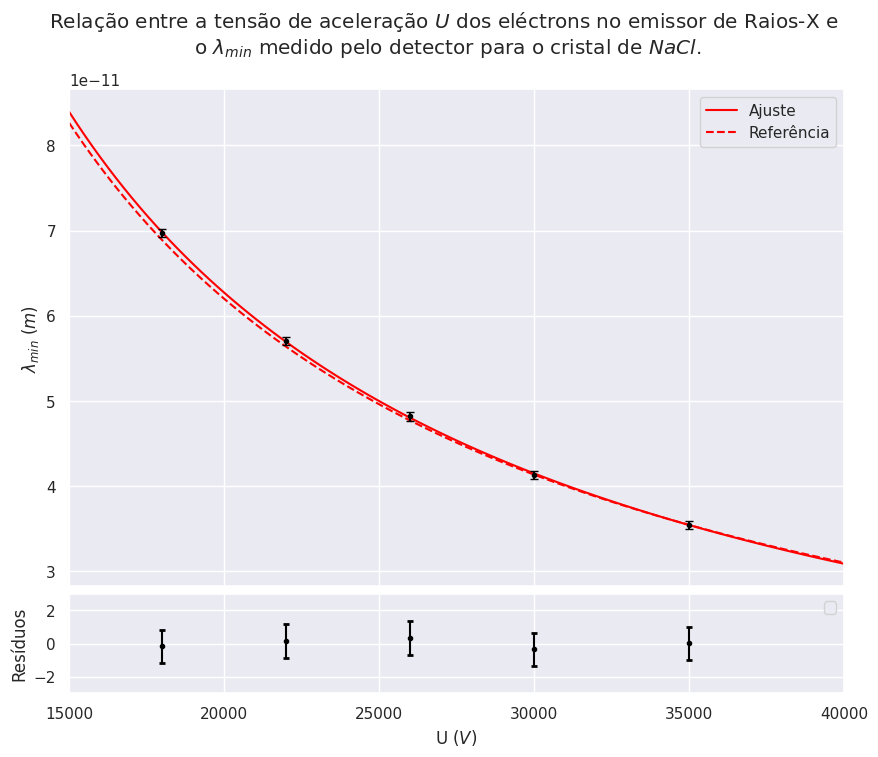

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.025, 'height_ratios': (5,1) })
plt.suptitle('Relação entre a tensão de aceleração $U$ dos eléctrons no emissor de Raios-X e\n o $\\lambda_{min}$ medido pelo detector para o cristal de $NaCl$.')
 

x = np.linspace(15, 40, 100) * 1E3
sns.lineplot(x=x, y=popt[0]/x+popt[1], color='red', label=f'Ajuste', ax=axs[0])

sns.lineplot(x=x, y=h*c/x, color='red', linestyle='dashed', label=f'Referência', ax=axs[0])

axs[0].errorbar(
    x=min_wl['voltages'],
    y=min_wl['wavelength'],
    yerr=min_wl['sWavelength'],
    fmt='.', color='black', capsize=3, capthick=1,
    label='Dados'
)

axs[1].errorbar(
    x=min_wl['voltages'],
    y=(min_wl['wavelength'] - popt[0] / min_wl['voltages'] - popt[1]) / min_wl['sWavelength'],
    yerr=1,
    fmt='.', color='black', capsize=2, capthick=2
)

axs[0].set_ylabel('$\\lambda_{min}$ ($m$)')
axs[1].set_xlabel('U ($V$)')
axs[1].set_ylabel('Resíduos')

plt.xlim(15E3, 40E3)
plt.ylim(-3, 3)
plt.legend()

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.sum( ( min_wl['wavelength'] - popt[0] / min_wl['voltages'] - popt[1] )**2 / ( min_wl['sWavelength'] )**2 )

0.2829177556405841

In [ ]:
h_measured = popt[0] / c, np.sqrt(pcov[0][0])

In [ ]:
print('Valor obtido:\n[h]:\t{:.5e} eV/s\t{:.5e} eV/s\nDELTA:\t{:.2f}%\nzTEST:\t{:.5e}'.format(
    h_measured[0], h_measured[1],
    100 * ( h_measured[0] - h ) / h,
    (h_measured[0] - h) / h_measured[1]
))

Valor obtido:
[h]:	4.25001e-15 eV/s	7.09760e-09 eV/s
DELTA:	2.76%
zTEST:	1.61103e-08


In [ ]:
data_fit['NaCl'] = pd.DataFrame(min_wl)
curves['NaCl'] = popt

### $KBr$ - Brometo de Potássio

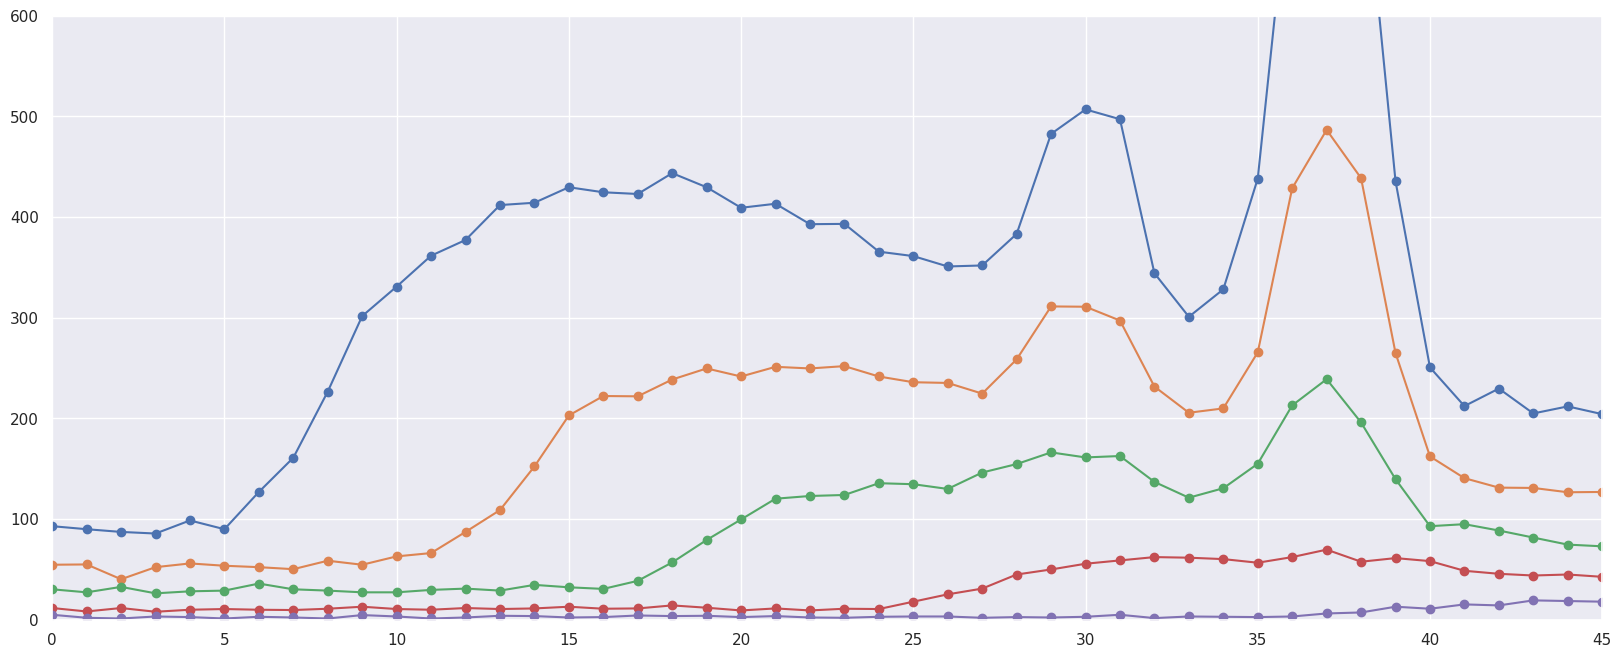

In [ ]:
plt.figure(figsize=(20,8))
for i in range(5): plt.plot(df['KBr'][f'R{i+1}'], marker='o')
plt.xlim(0, 45)
plt.ylim(0, 600)
plt.show()

In [ ]:
indexes = [ 5, 9, 16, 24, 36 ]
min_wl = {
    'voltages': voltages,
    'wavelength': df['KBr']['wavelength'][indexes],
    'sWavelength': df['KBr']['sWavelength'][indexes] 
  }

In [ ]:
popt, pcov = curve_fit(
    lambda x, a, b: a / x + b,
    xdata=min_wl['voltages'],
    ydata=min_wl['wavelength'],
    sigma=min_wl['sWavelength'],
    p0=(h*c, 0)
  )

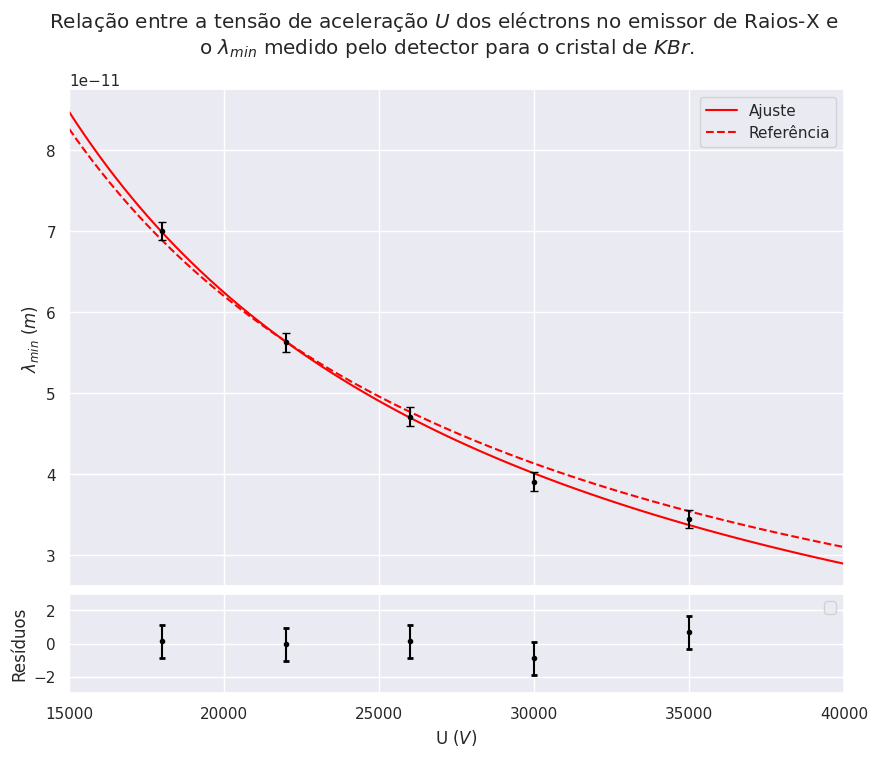

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.025, 'height_ratios': (5,1) })
plt.suptitle('Relação entre a tensão de aceleração $U$ dos eléctrons no emissor de Raios-X e\n o $\\lambda_{min}$ medido pelo detector para o cristal de $KBr$.')


x = np.linspace(15, 40, 100) * 1E3
sns.lineplot(x=x, y=popt[0] / x + popt[1], color='red', label=f'Ajuste', ax=axs[0])

sns.lineplot(x=x, y=h*c/x, color='red', linestyle='dashed', label=f'Referência', ax=axs[0])

axs[0].errorbar(
    x=min_wl['voltages'],
    y=min_wl['wavelength'],
    yerr=min_wl['sWavelength'],
    fmt='.', color='black', capsize=3, capthick=1,
    label='Dados'
)

axs[1].errorbar(
    x=min_wl['voltages'],
    y=(min_wl['wavelength'] - popt[0] / min_wl['voltages'] - popt[1]) / min_wl['sWavelength'],
    yerr=1,
    fmt='.', color='black', capsize=2, capthick=2
)

axs[0].set_ylabel('$\\lambda_{min}$ ($m$)')
axs[1].set_xlabel('U ($V$)')
axs[1].set_ylabel('Resíduos')

plt.xlim(15E3, 40E3)
plt.ylim(-3, 3)
plt.legend()

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.sum( ( min_wl['wavelength'] - popt[0] / min_wl['voltages'] - popt[1] )**2 / ( min_wl['sWavelength'] )**2 )

1.2698703141551269

In [ ]:
h_measured = popt[0] / c, np.sqrt(pcov[0][0])

In [ ]:
print('Valor obtido:\n[h]:\t{:.5e} eV/s\t{:.5e} eV/s\nDELTA:\t{:.2f}%\nzTEST:\t{:.5e}'.format(
    h_measured[0], h_measured[1],
    100 * ( h_measured[0] - h ) / h,
    (h_measured[0] - h) / h_measured[1]
))

Valor obtido:
[h]:	4.46849e-15 eV/s	3.51900e-08 eV/s
DELTA:	8.05%
zTEST:	9.45781e-09


In [ ]:
data_fit['KBr'] = pd.DataFrame(min_wl)
curves['KBr'] = popt

### Curvas dos ajustes para os dados dos cristais de $NaCl$ e $KBr$ superpostas

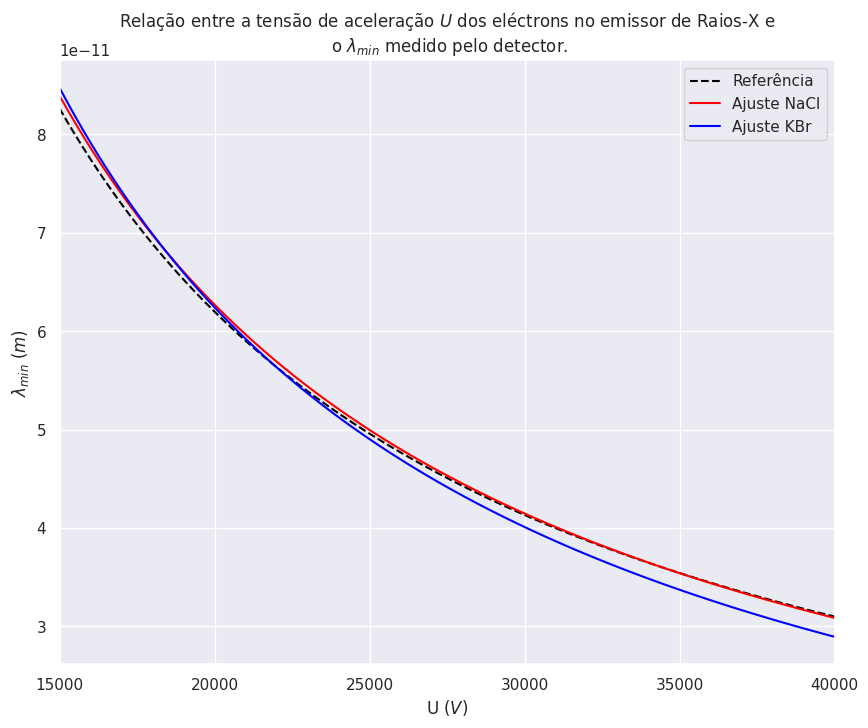

In [ ]:
plt.title('Relação entre a tensão de aceleração $U$ dos eléctrons no emissor de Raios-X e\n o $\\lambda_{min}$ medido pelo detector.')

x = np.linspace(15, 40, 100) * 1E3
sns.lineplot(x=x, y=h*c/x, color='black', linestyle='dashed', label=f'Referência')

sns.lineplot(x=x, y=curves['NaCl'][0] / x + curves['NaCl'][1], color='red', label=f'Ajuste NaCl')
sns.lineplot(x=x, y=curves['KBr'][0] / x + curves['KBr'][1], color='blue', label=f'Ajuste KBr')


plt.ylabel('$\\lambda_{min}$ ($m$)')
plt.xlabel('U ($V$)')

plt.xlim(15E3, 40E3)
plt.legend()

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()